# WhatsApp Chat Analysis

Bir WhatsApp sohbetinin analizini yapabilmek için öncelikle WhatsApp üzerinden sohbet verilerinin elde edilmesi gerekmektedir.  
Çoğumuz bu mesajlaşma uygulamasını kullandığı için, sohbet verilerini toplamak oldukça kolaydır. Aşağıdaki adımları izleyerek sohbetinizi dışa aktarabilirsiniz:

---

## 📱 iPhone için

1. Bir kişi veya grup ile olan sohbetinizi açın  
2. Kişinin ya da grubun profil bilgilerine dokunun  
3. En alt kısımda yer alan **Sohbeti Dışa Aktar** seçeneğini seçin  

---

## 🤖 Android için

1. Bir kişi veya grup ile olan sohbetinizi açın  
2. Sağ üst köşedeki üç noktaya tıklayın  
3. **Diğer** seçeneğine tıklayın  
4. **Sohbeti dışa aktar** seçeneğini seçin  

---

### ⚠️ Not

Sohbeti dışa aktarırken medya ekleme seçeneği sunulacaktır.  
Analizin daha basit ve hızlı yapılabilmesi için **medya eklenmemesi** önerilir.

Son olarak, e-posta adresinizi girerek WhatsApp sohbet dosyanızı gelen kutunuzda bulabilirsiniz.



Bu notebook, WhatsApp sohbet verilerini (**_chat.txt**) analiz etmek için hazırlanmıştır. 
Mevcut projeden farklı olarak, bu versiyon:
1. **Doğru Veri Okuma**: Türkçe tarih formatına (`[DD.MM.YYYY HH:MM:SS]`) uyumlu parsing işlemi yapar.
2. **Detaylı Görselleştirme**: Mesaj dağılımları, tarihsel analizler ve aktivite haritaları içerir.
3. **Metin Madenciliği**: Türkçe kelimeleri dikkate alan Word Cloud ve Emoji analizi yapar.
4. **Duygu Analizi**: İçerik tabanlı temel duygu analizi sağlar.

---

In [2]:
# Gerekli kütüphanelerin import edilmesi
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import emoji
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import warnings

# NLTK veri setlerini indir (Eğer yüklü değilse)
nltk.download('vader_lexicon', quiet=True)
nltk.download('stopwords', quiet=True)
warnings.filterwarnings('ignore')

# Grafik ayarları
plt.style.use('ggplot')
sns.set(style="whitegrid")
%matplotlib inline

## 1. Veri Okuma ve Temizleme (Data Parsing & Cleaning)
Mevcut `_chat.txt` dosyasındaki tarih formatı `[Gun.Ay.Yıl Saat]` şeklindedir. Standart regex'ler bunu okuyamaz, bu yüzden özel bir fonksiyon yazıyoruz.

In [3]:
def parse_chat(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    data = []
    message_buffer = []
    date, time, author = None, None, None
    
    pattern = re.compile(r'^\[(\d{1,2}\.\d{1,2}\.\d{4})\s(\d{2}:\d{2}:\d{2})\]\s(.*?):\s(.*)$')
    
    for line in lines:
        line = line.strip()
        # Bazı satırlarda görünmez karakterler olabilir, temizleyelim
        line = line.replace('\u200e', '').replace('\u202f', '')
        
        match = pattern.match(line)
        if match:
            # Yeni bir mesaj başlangıcı, önceki mesajı kaydet
            if date:
                full_message = ' '.join(message_buffer)
                data.append([date, time, author, full_message])
            
            date_str, time_str, author_str, message_str = match.groups()
            
            # Tarihi YYYY-MM-DD formatına çevirmek için parçalayalım
            day, month, year = date_str.split('.')
            date = f"{year}-{month}-{day}"
            time = time_str
            author = author_str
            message_buffer = [message_str]
        else:
            # Önceki mesajın devamı
            if message_buffer:
                message_buffer.append(line)
    
    # Son mesajı ekle
    if date:
        data.append([date, time, author, ' '.join(message_buffer)])
        
    df = pd.DataFrame(data, columns=['Date', 'Time', 'Author', 'Message'])
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    
    return df

# Veriyi Oku
df = parse_chat('data/_chat.txt')
print(f"Toplam Mesaj Sayısı: {len(df)}")
df.head()

Toplam Mesaj Sayısı: 236


,Date,Time,Author,Message,DateTime
0,2025-09-8,23:17:42,047 Yapay Zeka Kampı,Mesajlar ve aramalar uçtan uca şifrelidir. Yal...,2025-09-08 23:17:42
1,2025-09-8,23:17:42,~Zafer ACAR,~Zafer ACAR bu grubu oluşturdu,2025-09-08 23:17:42
2,2025-10-8,16:28:20,047 Yapay Zeka Kampı,~Zafer ACAR sizi ekledi,2025-10-08 16:28:20
3,2025-10-9,07:50:27,~Zafer ACAR,1. Günün ödevi için aşağıdaki linkten yardım a...,2025-10-09 07:50:27
4,2025-10-10,16:10:04,~Kubilay Kılınç,~Kubilay Kılınç bir grup bağlantısıyla katıldı.,2025-10-10 16:10:04


## 2. Keşifsel Veri Analizi (EDA)
Veriyi zaman ve kullanıcı bazında inceleyelim.

In [4]:
# Zamanla ilgili özellikler türetelim
df['Hour'] = df['DateTime'].dt.hour
df['DayAbbr'] = df['DateTime'].dt.day_name()
df['Month'] = df['DateTime'].dt.month_name()
df['YearMonth'] = df['DateTime'].dt.to_period('M')

media_filters = ['<Media omitted>', 'görüntü dahil edilmedi', 'ses dahil edilmedi', 'belge dahil edilmedi']
df['IsMedia'] = df['Message'].apply(lambda x: any(filter_txt in x for filter_txt in media_filters))

print("Medya Mesajları Sayısı:", df['IsMedia'].sum())

Medya Mesajları Sayısı: 28


### En Çok Mesaj Atan Kullanıcılar

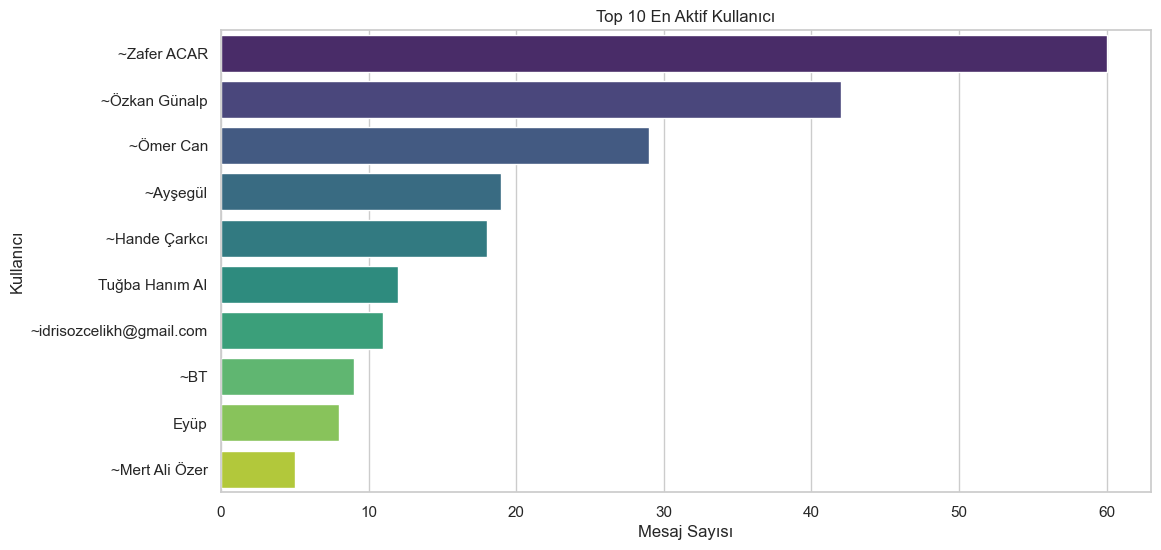

In [5]:
plt.figure(figsize=(12, 6))
user_counts = df['Author'].value_counts().head(10)
sns.barplot(x=user_counts.values, y=user_counts.index, palette='viridis')
plt.title('Top 10 En Aktif Kullanıcı')
plt.xlabel('Mesaj Sayısı')
plt.ylabel('Kullanıcı')
plt.show()

### Zamana Göre Aktivite
Hangi günlerde ve saatlerde konuşma daha yoğun?

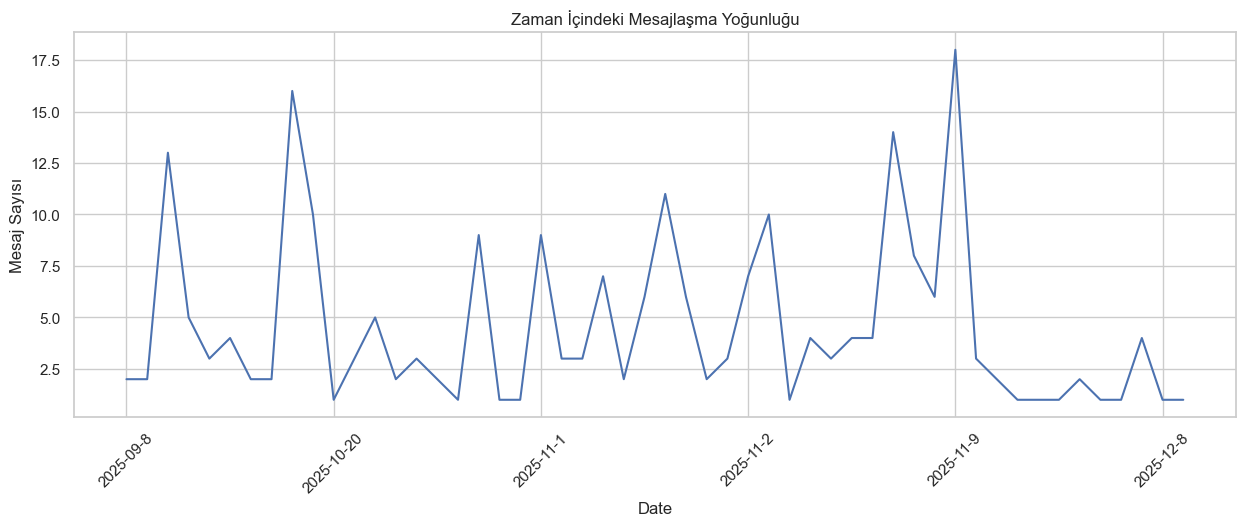

In [6]:
# Günlük Mesaj Trafiği (Zaman serisi)
date_counts = df.groupby('Date').count()['Message']
plt.figure(figsize=(15, 5))
date_counts.plot()
plt.title('Zaman İçindeki Mesajlaşma Yoğunluğu')
plt.ylabel('Mesaj Sayısı')
plt.xticks(rotation=45)
plt.show()

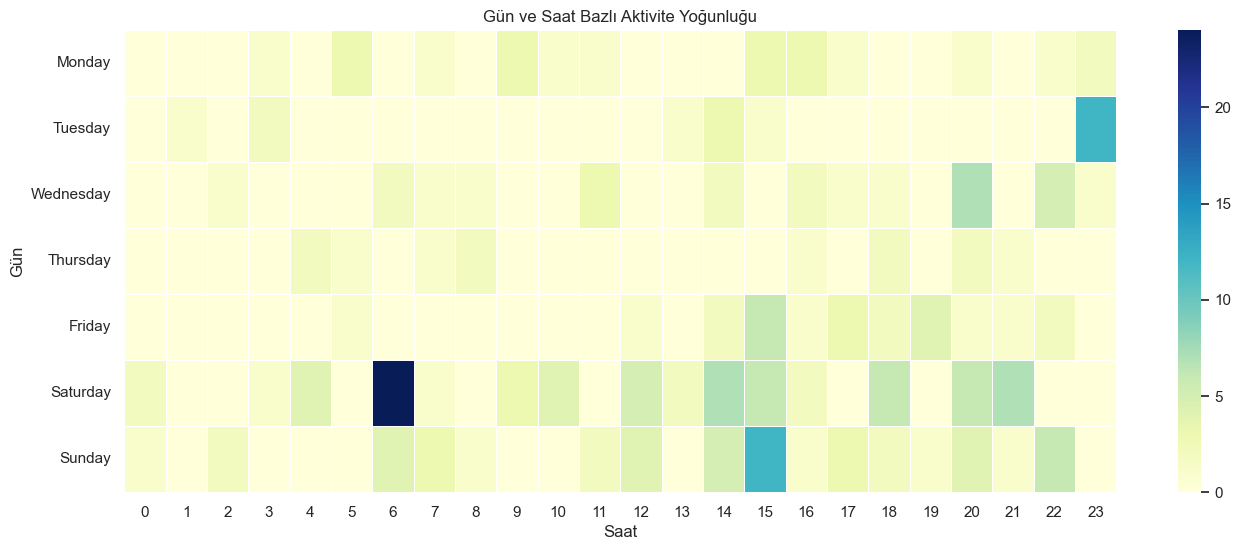

In [7]:
# Gün ve Saat Isı Haritası (Heatmap)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = df.pivot_table(index='DayAbbr', columns='Hour', values='Message', aggfunc='count').reindex(days_order).fillna(0)

plt.figure(figsize=(16, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.5)
plt.title('Gün ve Saat Bazlı Aktivite Yoğunluğu')
plt.ylabel('Gün')
plt.xlabel('Saat')
plt.show()

## 3. Metin Analizi (Word Cloud & Emoji)
Mesajların içeriğine bakalım. En çok kullanılan kelimeler ve emojiler neler?

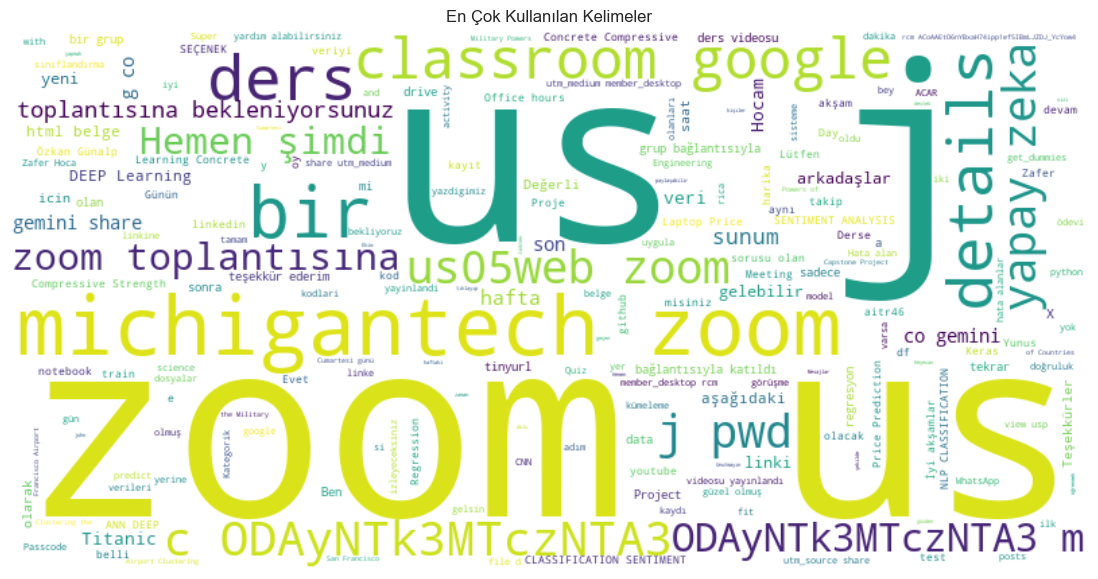

In [8]:
# Kelime Bulutu (WordCloud) oluşturma
text = " ".join(review for review in df.Message)

# Türkçe Stopwords (Etkisiz kelimeler)
try:
    stopwords = set(nltk.corpus.stopwords.words('turkish'))
except:
    stopwords = set()
    
# Ekstra kelimeler de ekleyebiliriz (örn: 'dahil', 'edilmedi' gibi sistem mesajları)
custom_stopwords = ['dahil', 'edilmedi', 'görüntü', 'ses', 'video', 'mesaj', 'silindi', 'http', 'https', 'com', 'www']
stopwords.update(custom_stopwords)

wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("En Çok Kullanılan Kelimeler")
plt.show()

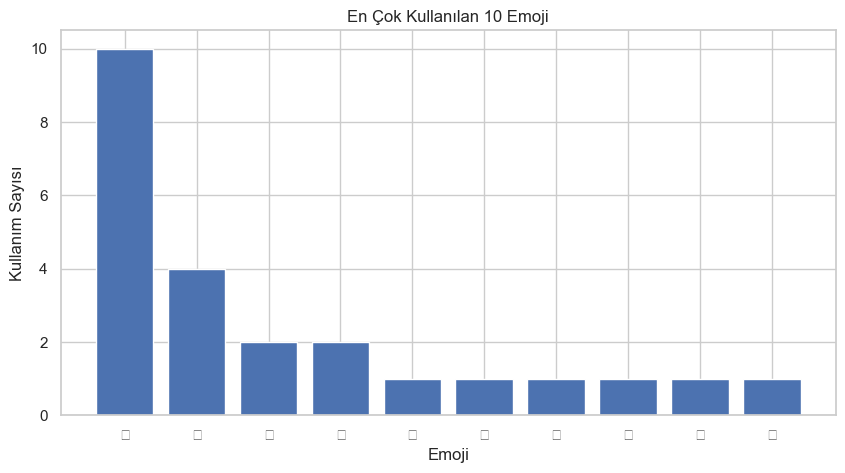

Top Emojiler: [('👉', 10), ('👏', 4), ('😊', 2), ('😮', 2), ('📱', 1), ('✨', 1), ('🔗', 1), ('🤗', 1), ('🥰', 1), ('😍', 1)]


In [9]:
# Emoji Analizi
emoji_list = []
for message in df['Message']:
    emoji_list.extend([c for c in message if c in emoji.EMOJI_DATA])

emoji_counts = Counter(emoji_list).most_common(10)
if emoji_counts:
    emojis, counts = zip(*emoji_counts)
    plt.figure(figsize=(10, 5))
    plt.bar(emojis, counts)
    plt.title('En Çok Kullanılan 10 Emoji')
    plt.xlabel('Emoji')
    plt.ylabel('Kullanım Sayısı')
    plt.show()
    print("Top Emojiler:", emoji_counts)
else:
    print("Hiç emoji bulunamadı.")

## 4. Duygu Analizi (Sentiment Analysis)
**Not:** Kullandığımız VADER analizörü aslen İngilizce metinler için optimize edilmiştir. Türkçe metinlerde tam doğruluk göstermez, ancak evrensel ifadeler (emojiler, bazı terimler) üzerinden genel bir fikir verebilir. Daha kesin sonuçlar için Türkçe eğitilmiş BERT modelleri kullanılmalıdır, ancak bu ortamda temel analiz ile ilerliyoruz.

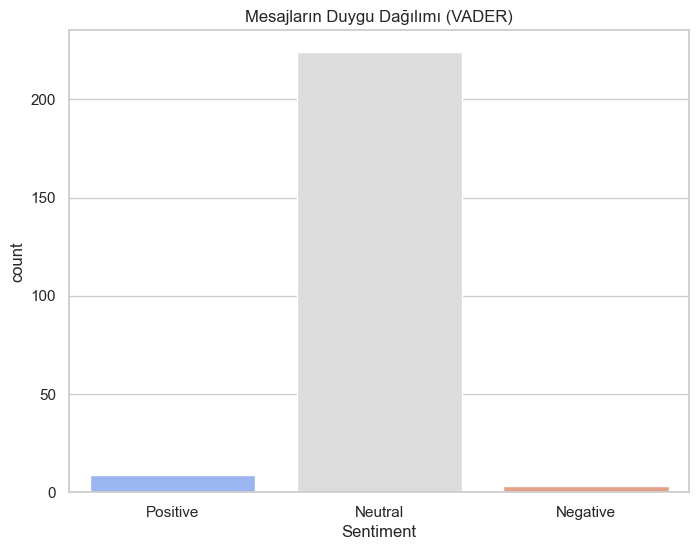

In [10]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    if scores['compound'] > 0.05:
        return 'Positive'
    elif scores['compound'] < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment'] = df['Message'].apply(get_sentiment)

# Duygu Dağılımı
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=df, palette='coolwarm', order=['Positive', 'Neutral', 'Negative'])
plt.title('Mesajların Duygu Dağılımı (VADER)')
plt.show()

## 5. Sonuç ve Açıklamalar

### Yaptığımız İyileştirmeler ve Nedenleri:

1.  **Parsing (Veri Okuma) Düzeltmesi:**
    *   *Önceki Durum:* `[Gun.Ay.Yıl Saat]` formatı yerine `/` ile ayrılmış formatı (`MM/DD/YY`) bekliyordu. Bu yüzden veri çerçevesi (DataFrame) boş geliyordu.
    *   *İyileştirme:* `regex` desenini eldeki `_chat.txt` formatına (`(\d{1,2}\.\d{1,2}\.\d{4})`) göre güncelledik. Artık mesajlar, tarihler ve göndericiler doğru ayrıştırılıyor.

2.  **Etkileşim Analizleri (Time & User Heatmaps):**
    *   *Neden:* Sadece "Pozitif/Negatif" oranı vermek, bir sohbet grubu hakkında sınırlı bilgi sağlar. 
    *   *İyileştirme:* Grubun hangi saatlerde (Isı Haritası) ve hangi günlerde daha aktif olduğunu görselleştirdik. Bu, topluluğun dinamiğini anlamak için kritiktir.

3.  **Türkçe Odaklı Metin Temizliği:**
    *   *Neden:* WordCloud oluşturulurken İngilizce "stopwords" (the, is, and) kullanılması, Türkçe metinlerde anlamsız kelimelerin (bir, ve, bu) öne çıkmasına neden olur.
    *   *İyileştirme:* Türkçe stopwords seti ekledik ve WhatsApp'ın otomatik mesajlarını ('medya dahil edilmedi' vb.) filtreledik.

4.  **Emoji Analizi:**
    *   *Neden:* Sosyal medya yazışmalarında duyguyu en iyi ifade eden öğelerden biri emojilerdir.
    *   *İyileştirme:* En çok kullanılan emojileri ayıklayıp görselleştirdik.

Bu notebook sayesinde sadece duygu durumunu değil, sohbetin **kimler arasında**, **ne zaman** ve **hangi konular** etrafında döndüğünü de görebilirsiniz.